In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
import os
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("../features/features_global.csv", sep=',', header=None)

C:\Program Files\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df.isnull().sum().sum()

0

In [4]:
df.ix[:,0].value_counts()


blue      7037
purple    6696
Name: 0, dtype: int64

In [5]:
df = df.fillna(0)

In [6]:
no_nulls = df.apply(lambda row : 
          any([ e == ("null") for e in row ])
       , axis=1) 

In [7]:
no_nulls[212]

False

In [8]:
df.loc[[212]]

,0,1,2,3,4,5,6,7,8,9,...,162,163,164,165,166,167,168,169,170,171
212,purple,3032929911,0.428571,394.617,1.92308,0.923077,2.78571,158539,21724.8,24917.4,...,30202.8,531.632,5.44737,5.03158,0.363158,-0.242105,260.316,413.189,-8.27895,1.35263


In [9]:
no_nulls.shape

(13733,)

In [10]:
df = df[~no_nulls]
df = df.apply(pd.to_numeric, errors='ignore')


In [11]:
df.head(5)

,0,1,2,3,4,5,6,7,8,9,...,162,163,164,165,166,167,168,169,170,171
0,blue,2984814498,0.650000,423.95993,1.917431,0.917431,2.900000,133402.100,17926.000,16480.800,...,13711.350,114.10000,1.190000,1.685000,-0.402500,-0.352500,193.48500,332.70502,-10.030000,-7.407500
1,purple,3034035764,0.526316,402.25280,2.000000,1.000000,2.157895,137797.310,17697.053,17959.790,...,17441.264,302.21054,1.189474,1.642105,0.100000,-0.081579,200.77895,350.03687,4.418421,30.384210
2,purple,3036731710,0.409091,421.79210,2.215569,1.215569,3.636364,154794.270,23505.592,24949.682,...,29733.684,782.63160,0.326316,0.773684,-0.036842,-0.413158,223.42105,339.43683,-9.331579,-31.594736
3,purple,3018436026,0.473684,384.25073,1.917526,0.917526,2.368421,136257.270,17298.736,18882.053,...,14255.750,136.25000,0.235000,0.405000,-0.330000,-0.022500,165.56500,310.27000,0.042500,65.232500
4,blue,3026930091,0.478261,398.31564,2.887755,1.887755,4.173913,125274.305,17986.130,22280.957,...,16022.895,226.68420,7.163158,6.894737,0.857895,0.323684,288.94210,461.35263,24.378946,56.265793


In [12]:
df.shape

(13660, 172)

In [13]:
#df = df.replace(to_replace='null', value=0)
#df = df.replace(to_replace='infinity', value=0)

In [26]:
#Global constants
seed = 7875
validation_size = 750
feature_count = df.shape[1] - 2

#feed forward neural net
n_nodes_hl1 = 300
n_nodes_hl2 = 100
n_nodes_hl3 = 50

#cycles of feed forward + backprop on all K-folded samples
hm_epochs = 2000

n_classes = 2

In [15]:
import pickle

X = np.asarray(df.ix[:,2:feature_count+2])
#standardize X
meanX = np.mean(X, axis = 0)
stdX = np.std(X, axis = 0)

f = open('mean.pckl', 'wb')
pickle.dump(meanX, f)
f.close()

f = open('std.pckl', 'wb')
pickle.dump(stdX, f)
f.close()

X = (X - meanX) / stdX

Y_1 = np.asarray(df.ix[:,0])
Y_1 = [int(y == "purple") for y in Y_1]
#one hot Y
Y = np.zeros(shape=(len(Y_1), n_classes))
Y[np.arange(len(Y_1)), Y_1] = 1
    
validation_features = X[:validation_size]
validation_labels = Y[:validation_size]

train_features = X[validation_size:]
train_labels = Y[validation_size:]

num_examples = train_features.shape[0]

In [16]:
def neural_network_model(data):
    
    dropout_prob = 0.5
    
    hidden_1_layer = {
        'weights': tf.Variable(tf.truncated_normal([feature_count, n_nodes_hl1], stddev=0.1, seed=seed)),
        'biases': tf.Variable(tf.constant(1.0, shape=[n_nodes_hl1]))
    }
    
    hidden_2_layer = {
        'weights': tf.Variable(tf.truncated_normal([n_nodes_hl1, n_nodes_hl2], stddev=0.1, seed=seed)),
        'biases': tf.Variable(tf.constant(1.0, shape=[n_nodes_hl2]))
    }
    
    hidden_3_layer = {
        'weights': tf.Variable(tf.truncated_normal([n_nodes_hl2, n_nodes_hl3], stddev=0.1, seed=seed)),
        'biases': tf.Variable(tf.constant(1.0, shape=[n_nodes_hl3]))
    }
    
    output_layer = {
        'weights': tf.Variable(tf.truncated_normal([n_nodes_hl1, n_classes], stddev=0.1, seed=seed)),
        'biases': tf.Variable(tf.constant(1.0, shape=[n_classes]))
    }
    
    l1 = tf.add(tf.matmul(data, hidden_1_layer['weights']), hidden_1_layer['biases'])
    l1 = tf.nn.relu6(l1)
    
    l1_drop = tf.nn.dropout(l1, dropout_prob, seed=seed)
    
    l2 = tf.add(tf.matmul(l1_drop, hidden_2_layer['weights']), hidden_2_layer['biases'])
    l2 = tf.nn.relu6(l2)
    
    l2_drop = tf.nn.dropout(l2, dropout_prob, seed=seed)
    
    l3 = tf.add(tf.matmul(l2, hidden_3_layer['weights']), hidden_3_layer['biases'])
    l3 = tf.nn.sigmoid(l3)
    
    l3_drop = tf.nn.dropout(l3, dropout_prob, seed=seed)
    
    output = tf.matmul(l1_drop, output_layer['weights']) +  output_layer['biases']
    
    regularizers = (tf.nn.l2_loss(hidden_1_layer['weights']) + tf.nn.l2_loss(hidden_1_layer['biases']) +
                                tf.nn.l2_loss(output_layer['weights']) + tf.nn.l2_loss(output_layer['biases']))
    
    return output, regularizers

In [17]:
def display_stat(x_range, trains, tests, vals, acc_0s, acc_1s):
    
    #plt.plot(x_range, trains,'-b', label='Training acc')
    #plt.plot(x_range, vals,'-g', label='Validation acc')
    #plt.plot(x_range, tests,'-y', label='Test acc')
    plt.plot(x_range, acc_0s,'-r', label='Acc Class 0')
    plt.plot(x_range, acc_1s,'-k', label='Acc Class 1')

    plt.legend(loc='lower right', frameon=False)
    plt.ylim(ymax = 1.1, ymin = 0.0)

    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.show()

In [18]:
def train_neural_network_CV(x, lambda_):
    
    vals = []
    trains = []
    tests = []
    x_range = []
    
    f1_vals = []
    
    acc_1s = []
    acc_0s = []
    
    prediction, regularizers = neural_network_model(x)
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(prediction, y))
    #log_loss = tf.contrib.losses.log_loss(predictions=prediction, labels=y)

    #Eval this to get probability of [winning,losing]
    prob = tf.nn.softmax(prediction)
    
    #learning rate can be passed
    optimizer = tf.train.AdamOptimizer(1e-4).minimize(cost + lambda_ * regularizers)
    
    #metrics
    correct_prediction = tf.equal(tf.argmax(prediction,1), tf.argmax(y,1))
    false_prediction = tf.logical_not(correct_prediction)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float'))

    #use for f1 score if needed
    true_positives = tf.reduce_sum(tf.to_int32(tf.logical_and(correct_prediction, tf.equal(tf.argmax(tf.nn.softmax(y),1), True) )))
    false_positives = tf.reduce_sum(tf.to_int32(tf.logical_and(false_prediction, tf.equal(tf.argmax(tf.nn.softmax(y),1), True) )))
    true_negatives = tf.reduce_sum(tf.to_int32(tf.logical_and(correct_prediction, tf.equal(tf.argmax(tf.nn.softmax(y),1), False) )))
    false_negatives = tf.reduce_sum(tf.to_int32(tf.logical_and(false_prediction, tf.equal(tf.argmax(tf.nn.softmax(y),1), False) )))

    #acc for each class
    class_0 = tf.where(tf.equal(tf.argmax(y, 1), 0))
    class_0 = tf.reshape(class_0, [tf.shape(class_0)[0]])
    pred_0 = tf.gather(prediction, class_0)
    y_0 = tf.gather(y, class_0)
    class_0_correct = tf.equal(tf.argmax(pred_0,1), tf.argmax(y_0,1))
    acc_0 = tf.reduce_mean(tf.cast(class_0_correct, 'float'))
    
    class_1 = tf.where(tf.equal(tf.argmax(y, 1), 1))
    class_1 = tf.reshape(class_1, [tf.shape(class_1)[0]])
    pred_1 = tf.gather(prediction, class_1)
    y_1 = tf.gather(y, class_1)
    class_1_correct = tf.equal(tf.argmax(pred_1,1), tf.argmax(y_1,1))
    acc_1 = tf.reduce_mean(tf.cast(class_1_correct, 'float'))
    
    display_step = 1
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        for epoch in range(hm_epochs):
            #epoch_loss = 0
            fold_index = 0
            
            kf = KFold(n_splits=5, random_state=seed, shuffle=True)
            for train_index, test_index in kf.split(train_features, train_labels):
                fold_index += 1
                X_train, X_test = train_features[train_index], train_features[test_index]
                y_train, y_test = train_labels[train_index], train_labels[test_index]
                
                _, c = sess.run([optimizer, cost], feed_dict = {x: X_train, y: y_train})
                #epoch_loss += c
                
                train_accuracy = accuracy.eval(feed_dict={ x: X_train, y: y_train})  
                test_accuracy = accuracy.eval(feed_dict={ x: X_test, y: y_test})  
                
                # increase display_step after 10 iteration of same decimal
                if epoch%(display_step*10) == 0 and epoch:
                       display_step *= 10
    
                if (epoch%display_step == 0 or (epoch+1) == hm_epochs) and fold_index == 5:
                    print('train:%.4f, test:%.4f,  epoch %d, fold %d' % (train_accuracy, test_accuracy, epoch, fold_index))

                    #if (fold_index == kf.n_splits):
                    validation_accuracy = accuracy.eval(feed_dict={ x: validation_features, y: validation_labels})
                    print ('val:%.2f' % (validation_accuracy))
                    
                    tp = true_positives.eval(feed_dict={ x: validation_features, y: validation_labels})   
                    fp = false_positives.eval(feed_dict={ x: validation_features, y: validation_labels})  
                    fn = false_negatives.eval(feed_dict={ x: validation_features, y: validation_labels})

                    precision = float(tp) / float(tp+fn + 0.0000000000001)
                    recall = float(tp) / float(tp + fn + 0.0000000000001)
                    F1_val = 2 * ( precision * recall ) / ( precision + recall + 0.0000000000001 )

                    x_range.append(epoch)
                    vals.append(validation_accuracy)
                    trains.append(train_accuracy)
                    tests.append(test_accuracy)
                    f1_vals.append(F1_val)
                    
                    #print(validation_labels)
                    #print(class_1.eval(feed_dict={ x: validation_features, y: validation_labels})  )

                    acc_1s.append(acc_1.eval(feed_dict={ x: validation_features, y: validation_labels}))
                    acc_0s.append(acc_0.eval(feed_dict={ x: validation_features, y: validation_labels}))
                    
        saver = tf.train.Saver()
        save_path = saver.save(sess, model_path)        
        
        display_stat(x_range, trains, tests, vals, acc_0s, acc_1s)


train:0.4832, test:0.4915,  epoch 0, fold 5
val:0.47
train:0.4871, test:0.4926,  epoch 1, fold 5
val:0.44
train:0.4862, test:0.4946,  epoch 2, fold 5
val:0.47
train:0.4938, test:0.4888,  epoch 3, fold 5
val:0.48
train:0.4906, test:0.4930,  epoch 4, fold 5
val:0.47
train:0.4928, test:0.4903,  epoch 5, fold 5
val:0.47
train:0.5026, test:0.4988,  epoch 6, fold 5
val:0.48
train:0.4992, test:0.5229,  epoch 7, fold 5
val:0.50
train:0.5071, test:0.5116,  epoch 8, fold 5
val:0.46
train:0.5138, test:0.5101,  epoch 9, fold 5
val:0.53
train:0.5075, test:0.5248,  epoch 10, fold 5
val:0.50
train:0.5306, test:0.5376,  epoch 20, fold 5
val:0.51
train:0.5400, test:0.5391,  epoch 30, fold 5
val:0.54
train:0.5280, test:0.5263,  epoch 40, fold 5
val:0.53
train:0.5390, test:0.5380,  epoch 50, fold 5
val:0.55
train:0.5346, test:0.5248,  epoch 60, fold 5
val:0.53
train:0.5344, test:0.5500,  epoch 70, fold 5
val:0.53
train:0.5308, test:0.5453,  epoch 80, fold 5
val:0.49
train:0.5393, test:0.5662,  epoch 90, 

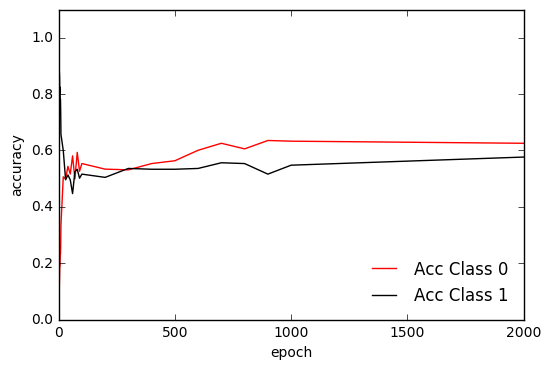

In [27]:
x = tf.placeholder('float', [None, feature_count])
y = tf.placeholder('float', [None, n_classes])

model_path = "./tmp2/model.ckpt"
save_dir = './tmp2/'
if not os.path.isdir(saqve_dir):
    os.mkdir(save_dir)
    
    
L2_lambda_ = 1.5e-3
train_neural_network_CV(x, L2_lambda_)

In [28]:
# Running a new session to predict based on model
#TODO make sure it works and test
prediction, regularizers = neural_network_model(x)
#Eval this to get probability of [winning,losing]
prob = tf.nn.softmax(prediction)

with tf.Session() as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())
    
#     saver.restore(sess, model_path)
    new_saver = tf.train.import_meta_graph(model_path + ".meta")
    new_saver.restore(sess, tf.train.latest_checkpoint('./tmp2'))
    
    #test random sample from validation test
    prob_test = validation_features[40].reshape((1,validation_features[0].shape[0]))
    prob_value = prob.eval(feed_dict={ x:prob_test})  
    print('probability test', prob_value)
    
    

probability test [[ 0.38545015  0.61454988]]


In [29]:
prob_test[0]

array([-0.32692872, -0.31204851, -0.32684987, -0.32688453, -0.32676454,
        5.21943154,  0.50826235,  0.38402118, -0.31375633, -0.32673353,
       -0.32671255, -0.32694888, -0.32693146, -0.31751632, -0.31180154,
       -0.32656407, -0.32534424, -0.32692872, -0.31120542, -0.32684049,
       -0.32687515, -0.32676819,  8.44878065,  0.94904214,  0.38893186,
       -0.30494007, -0.32671912, -0.32670471, -0.32695061, -0.3269403 ,
       -0.3168691 , -0.31103848, -0.32660903, -0.32516702, -0.32693602,
       -0.31333459, -0.32688257, -0.32691723, -0.32682657,  3.58025366,
        0.43102299,  0.67482447, -0.31463558, -0.32677403, -0.32673244,
       -0.32695061, -0.32691869, -0.31811666, -0.31209724, -0.32695061,
       -0.32602666, -0.32692689, -0.31192594, -0.32686835, -0.32690301,
       -0.32682292,  5.78753747,  0.55221774,  0.5592773 , -0.30653076,
       -0.3267972 , -0.32680522, -0.32692735, -0.32695061, -0.3169428 ,
       -0.31257845, -0.32593181, -0.32630248, -0.3269351 , -0.31